***1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.***

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

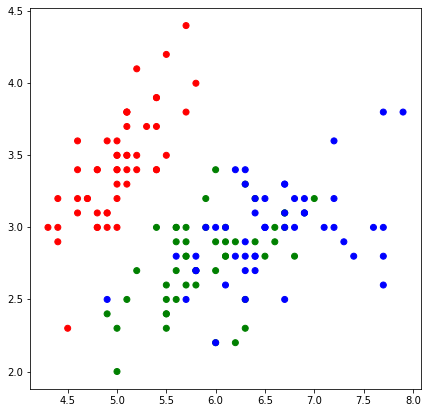

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [5]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [14]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем суммарный вес разных классов         ИЗМЕНЕНИЯ!
        q = 0.5
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += q ** d[0]  # определяем веса от расстояния 𝑑 

        # Записываем в список ответов класс с наибольшим общим весом
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [15]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [18]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.767


In [19]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

(2352, 2)


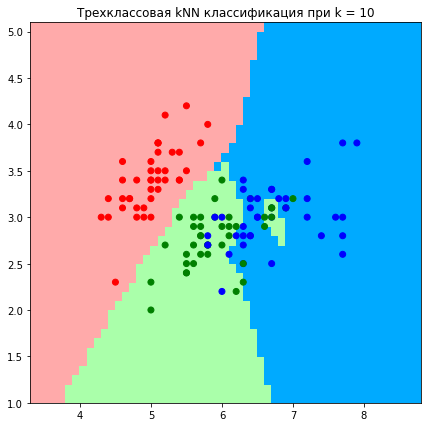

Wall time: 3.81 s


In [20]:
%%time
get_graph(X_train, y_train, k)

****2.* Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).***

In [21]:
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=100, random_state=1 )

In [22]:
import matplotlib.pyplot as plt

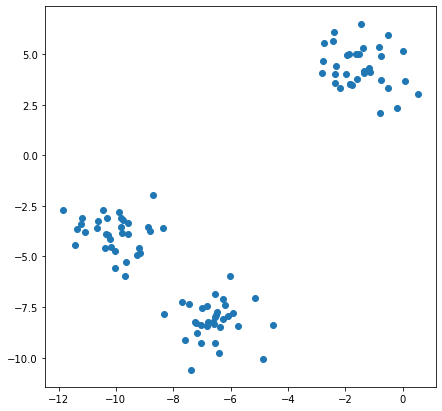

In [23]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

In [24]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения с новыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [25]:
def visualize(centroids, clusters):
    colors = ['r', 'g', 'b', 'orange', 'y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

In [28]:
# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# определим известное нам количество кластеров
k = 3

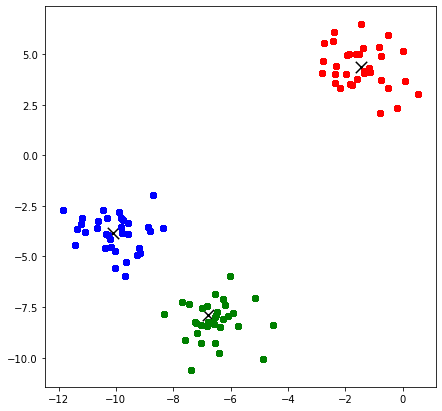

Wall time: 12.4 s


In [29]:
%%time
max_iterations = 10

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [36]:
def square_intracluster_distance(centroids, clusters):                               # !Изменения!
    sid = 0                                                                                                
    for centroid, cluster in zip(centroids, clusters.values()):  # в последних версиях python dict сохраняет порядок своих элементов
        distances = [e_metrics(centroid, el) ** 2 for el in cluster]
        sid += sum(distances) / len(cluster)
    return sid
        

In [38]:
sid = []
for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    s = square_intracluster_distance(centroids, clusters)
    sid.append(s)
    print(f"Cреднее квадратичное внутрикластерное расстояние при k = {k} равно {s}")

Cреднее квадратичное внутрикластерное расстояние при k = 1 равно 41.181537777044724
Cреднее квадратичное внутрикластерное расстояние при k = 2 равно 10.8818490946027
Cреднее квадратичное внутрикластерное расстояние при k = 3 равно 6.054744609629033
Cреднее квадратичное внутрикластерное расстояние при k = 4 равно 5.407238011751332
Cреднее квадратичное внутрикластерное расстояние при k = 5 равно 5.135706103163564
Cреднее квадратичное внутрикластерное расстояние при k = 6 равно 5.786977171344443
Cреднее квадратичное внутрикластерное расстояние при k = 7 равно 5.647205847915786
Cреднее квадратичное внутрикластерное расстояние при k = 8 равно 5.859161222488832
Cреднее квадратичное внутрикластерное расстояние при k = 9 равно 6.188134837104741
Cреднее квадратичное внутрикластерное расстояние при k = 10 равно 6.35591857885726


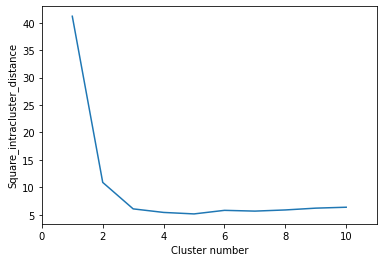

In [39]:
plt.xlabel('Cluster number')
plt.ylabel('Square_intracluster_distance')
plt.xlim(0, 11)
plt.plot(list(range(1, 11)), sid)
plt.show()

****3.* Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).***

In [40]:
def knn_2(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        
        test_distances = np.square(x_train - x)                                      #!ИЗМЕНЕНИЯ!
        test_distances = np.sqrt(test_distances[:, 0] + test_distances[:, 1]) # расчет расстояния от классифицируемого объекта
                                                                              # до объектов обучающей выборки
           
        # Добавляем столбец с ответами для объектов обучающей выборки
        test_distances = np.column_stack((test_distances, y_train))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и оставляем первые k элементов        
        test_distances = test_distances[test_distances[:, 0].argsort()][:k]
         
        q = 0.5
        
        for d in test_distances:
            classes[d[1]] += q ** d[0]  # определяем веса от расстояния 𝑑 

        # Записываем в список ответов класс с наибольшим общим весом
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [41]:
# Проверим работу knn_2

k = 10

y_pred_1 = knn(X_train, y_train, X_test, k)
y_pred_2 = knn_2(X_train, y_train, X_test, k)

print(f'Точность алгоритма knn при k = {k}: {accuracy(y_pred_1, y_test):.3f}')
print(f'Точность алгоритма knn_2 при k = {k}: {accuracy(y_pred_2, y_test):.3f}')
print(y_pred_1)
print(y_pred_2)

Точность алгоритма knn при k = 10: 0.767
Точность алгоритма knn_2 при k = 10: 0.767
[2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2]
[2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2]
